# Automatic mixed precision training and evaluation

This tutorial shows how to apply the automatic mixed precision (AMP) feature of PyTorch to training and validation programs.  
It's modified from the Spleen 3D segmentation tutorial notebook, and compares the training speed and memory usage with/without AMP.

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/MONAI/blob/master/examples/notebooks/automatic_mixed_precision.ipynb)

## Setup environment

In [2]:
%pip install -qU "monai[gdown, nibabel]"

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# temporarily need this, FIXME: remove when MONAI v0.3 released
%pip install -qU git+https://github.com/Project-MONAI/MONAI#egg=MONAI

In [3]:
%pip install -qU matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


## Setup imports

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import glob
import time
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from monai.config import get_torch_version_tuple
from monai.data import Dataset, CacheDataset, list_data_collate
from monai.transforms import \
    Compose, LoadNiftid, AddChanneld, ScaleIntensityRanged, CropForegroundd, FgBgToIndicesd, \
    RandCropByPosNegLabeld, DeleteItemsd, Spacingd, Orientationd, ToTensord
from monai.inferers import sliding_window_inference
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import compute_meandice
from monai.utils import set_determinism
from monai.config import print_config

print_config()

if get_torch_version_tuple() < (1, 6):
    raise RuntimeError('AMP feature only exists in PyTorch version greater than v1.6.')

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"root dir is: {root_dir}")

root dir is: /workspace/data/medical


## Download dataset

Downloads and extracts the Decathlon Spleen dataset.

In [3]:
resource = "https://drive.google.com/uc?id=1jzeNU1EKnK81PyTsrx0ujfNl-t0Jo8uE"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_root = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_root):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [4]:
train_images = sorted(glob.glob(os.path.join(data_root, 'imagesTr', '*.nii.gz')))
train_labels = sorted(glob.glob(os.path.join(data_root, 'labelsTr', '*.nii.gz')))
data_dicts = [{'image': image_name, 'label': label_name}
              for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Setup transforms for training and validation

In [5]:
def transformations():
    train_transforms = Compose([
        LoadNiftid(keys=['image', 'label']),
        AddChanneld(keys=['image', 'label']),
        Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.), mode=('bilinear', 'nearest')),
        Orientationd(keys=['image', 'label'], axcodes='RAS'),
        ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        # pre-compute foreground and background indexes and cache them to accelerate training
        FgBgToIndicesd(keys="label", fg_postfix="_fg", bg_postfix="_bg",image_key="image"),
        # randomly crop out patch samples from big image based on pos / neg ratio
        # the image centers of negative samples must be in valid image area
        RandCropByPosNegLabeld(keys=['image', 'label'], label_key='label', spatial_size=(96, 96, 96), pos=1,
                               neg=1, num_samples=4, fg_indices_key="label_fg", bg_indices_key="label_bg"),
        DeleteItemsd(keys=["label_fg", "label_bg"]),
        ToTensord(keys=['image', 'label'])
    ])
    val_transforms = Compose([
        LoadNiftid(keys=['image', 'label']),
        AddChanneld(keys=['image', 'label']),
        Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.), mode=('bilinear', 'nearest')),
        Orientationd(keys=['image', 'label'], axcodes='RAS'),
        ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        ToTensord(keys=['image', 'label'])
    ])
    return train_transforms, val_transforms

## Define a typical PyTorch training process
Usage of PyTorch AMP module refers to: https://pytorch.org/docs/stable/notes/amp_examples.html.

In [6]:
def train_process(amp=False):
    train_trans, val_trans = transformations()
    train_ds = CacheDataset(data=train_files, transform=train_trans, cache_rate=1.0, num_workers=4)
    val_ds = CacheDataset(data=val_files, transform=val_trans, cache_rate=1.0, num_workers=4)

    # use batch_size=2 to load images and use RandCropByPosNegLabeld
    # to generate 2 x 4 images for network training
    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=1, collate_fn=list_data_collate)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=1)
    device = torch.device('cuda:0')
    model = UNet(dimensions=3, in_channels=1, out_channels=2, channels=(16, 32, 64, 128, 256),
                 strides=(2, 2, 2, 2), num_res_units=2, norm=Norm.BATCH).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    scaler = torch.cuda.amp.GradScaler() if amp else None

    epoch_num = 600
    val_interval = 1  # do validation for every epoch
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = list()
    metric_values = list()
    epoch_times = list()
    total_start = time.time()
    for epoch in range(epoch_num):
        epoch_start = time.time()
        print('-' * 10)
        print(f"epoch {epoch + 1}/{epoch_num}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step_start = time.time()
            step += 1
            inputs, labels = batch_data['image'].to(device), batch_data['label'].to(device)
            optimizer.zero_grad()
            if amp and scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}"
                  f" step time: {(time.time() - step_start):.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                metric_sum = 0.
                metric_count = 0
                for val_data in val_loader:
                    val_inputs, val_labels = val_data['image'].to(device), val_data['label'].to(device)
                    roi_size = (160, 160, 160)
                    sw_batch_size = 4
                    if amp:
                        with torch.cuda.amp.autocast():
                            val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                    else:
                        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                    value = compute_meandice(y_pred=val_outputs, y=val_labels, include_background=False,
                                             to_onehot_y=True, mutually_exclusive=True)
                    metric_count += len(value)
                    metric_sum += value.sum().item()
                metric = metric_sum / metric_count
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), 'best_metric_model.pth')
                    print('saved new best metric model')
                print(f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                      f" best mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}")
        print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
        epoch_times.append(time.time() - epoch_start)
    print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}"
          f" total time: {(time.time() - total_start):.4f}")
    return epoch_num, epoch_loss_values, metric_values, epoch_times

## Enable deterministic and train with AMP

In [ ]:
set_determinism(seed=0)
amp_start = time.time()
epoch_num, amp_epoch_loss_values, amp_metric_values, amp_epoch_times = train_process(amp=True)
amp_total_time = time.time() - amp_start
print(f"total training time of {epoch_num} epochs with AMP: {amp_total_time:.4f}")

## Check the memory usage during training with AMP

In [8]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.memory_summary(0, abbreviated=True))

Tesla V100-PCIE-32GB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |    1159 MB |   68425 GB |   68425 GB |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |    1159 MB |   68425 GB |   68425 GB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |    2392 MB |    2392 MB |    2392 MB |       0 B  |
|------------------------------------------

## Enable deterministic and train without AMP
In order to correctly measure the memory usage, please restart the notebook and skip above AMP training.

In [ ]:
set_determinism(seed=0)
start = time.time()
epoch_num, epoch_loss_values, metric_values, epoch_times = train_process(amp=False)
total_time = time.time() - start
print(f"total training time of {epoch_num} epochs without AMP: {total_time:.4f}")

## Check the memory usage during training without AMP

In [8]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.memory_summary(0, abbreviated=True))

Tesla V100-PCIE-32GB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   37967 KB |    1732 MB |   87542 GB |   87542 GB |
|---------------------------------------------------------------------------|
| Active memory         |   37967 KB |    1732 MB |   87542 GB |   87542 GB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |    3654 MB |    3654 MB |    3654 MB |       0 B  |
|------------------------------------------

## Plot training loss and validation metrics

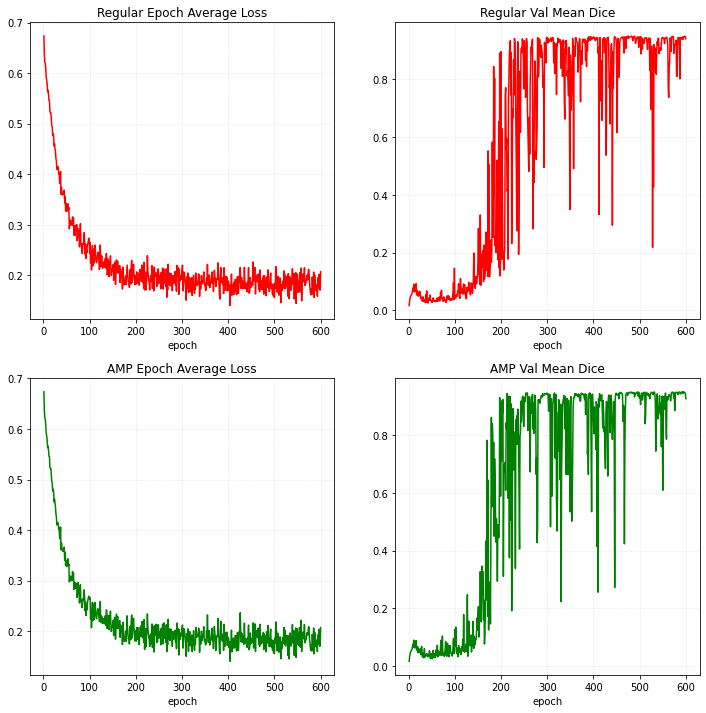

In [11]:
plt.figure('train', (12, 12))
plt.subplot(2, 2, 1)
plt.title('Regular Epoch Average Loss')
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='red')

plt.subplot(2, 2, 2)
plt.title('Regular Val Mean Dice')
x = [i + 1 for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='red')

plt.subplot(2, 2, 3)
plt.title('AMP Epoch Average Loss')
x = [i + 1 for i in range(len(amp_epoch_loss_values))]
y = amp_epoch_loss_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='green')

plt.subplot(2, 2, 4)
plt.title('AMP Val Mean Dice')
x = [i + 1 for i in range(len(amp_metric_values))]
y = amp_metric_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='green')
plt.show()

## Plot total time and every epoch time

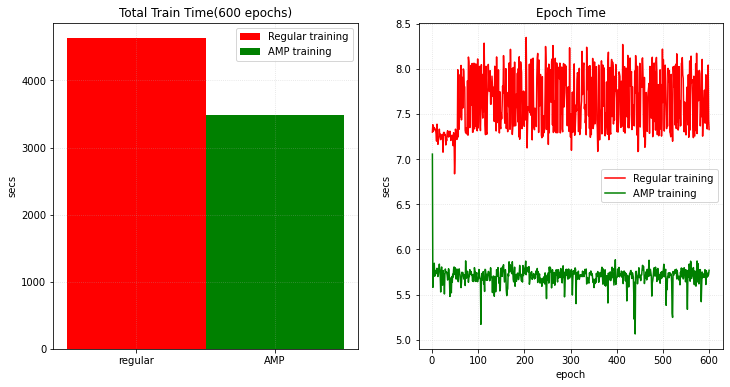

In [12]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title('Total Train Time(600 epochs)')
plt.bar('regular', total_time, 1, label='Regular training', color='red')
plt.bar('AMP', amp_total_time, 1, label='AMP training', color='green')
plt.ylabel('secs')
plt.grid(alpha=0.4, linestyle=':')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Epoch Time')
x = [i + 1 for i in range(len(epoch_times))]
plt.xlabel('epoch')
plt.ylabel('secs')
plt.plot(x, epoch_times, label='Regular training', color='red')
plt.plot(x, amp_epoch_times, label='AMP training', color='green')
plt.grid(alpha=0.4, linestyle=':')
plt.legend(loc='best')
plt.show()